In [80]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from scipy import signal
from time import time
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
from skimage.io import imread
from skimage.filters import gaussian

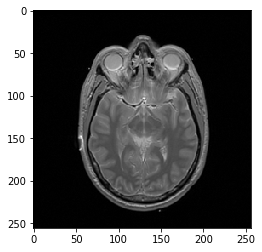

In [323]:
img = imread('../pd.jpg')
img = np.array(img[:,:,0], dtype=float)
img[100:110,100:110]
plt.imshow(img, cmap='gray');

In [519]:
img = imread('../peggys-cove.jpg')
img = np.array(img, dtype=float)
img = img[25:1525, 825:2325, :]

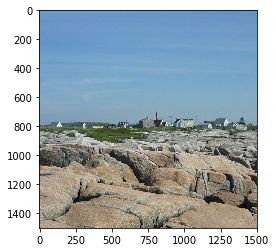

In [352]:
plt.imshow(img/255.);

In [55]:
start = time()
blur = gaussian(img, 10)
duration = time() - start
print(str(duration)+' seconds')

0.014734983444213867 seconds


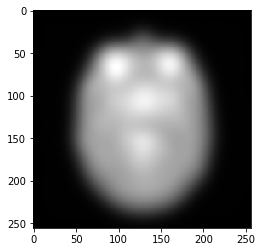

In [47]:
plt.imshow(blur, cmap='gray');

In [56]:
start = time()
Img = fft2(img)
duration = time() - start
print(str(duration)+' seconds')

0.00471186637878418 seconds


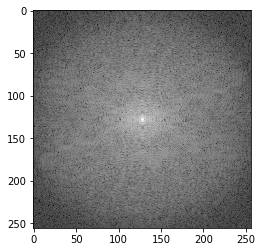

In [52]:
plt.imshow(np.log(abs(fftshift(Img[:,:]))), cmap='gray');

## Make a blur pyramid

In [572]:
sigmas = [1., 2, 3.5, 5., 20.]

In [573]:
def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]
    
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]
    g = np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    return g/np.sum(g.flatten())

In [574]:
def AutoCrop(img, relthresh=0.1):
    N = np.shape(img)[0]
    maximums = np.max(abs(img), axis=1) / np.max(abs(img))
    idx_low = list(maximums>0.1).index(True)
    if idx_low==0:
        return img
    else:
        idx_high = N - 1 - list(reversed(maximums>0.1)).index(True)
    return img[idx_low:idx_high,idx_low:idx_high]

In [575]:
def AutoCropFilter(N, fwhm=2., relthresh=0.1):
    g = makeGaussian(N, fwhm=fwhm)
    G = fftshift(fft2(ifftshift(g)))
    return AutoCrop(G, relthresh=relthresh)

(16, 16)


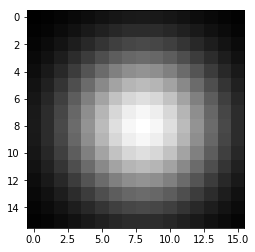

In [576]:
blah = AutoCropFilter(256, fwhm=25.)
print(np.shape(blah))
plt.imshow(abs(blah), cmap='gray');

In [577]:
def MakeImagePyramid(img, sigmas):
    '''
    pyramid = MakeImagePyramid(img, sigmas)
    
    Construct a list of blurred and subsampled versions of an image.
    
    Inputs:
      img      square image
      sigmas   list of standard deviations for the Gaussian blur kernels
    
    Output:
      pyramid  list of images, varying in size
    '''
    f_pyramid = []
    #F_pyramid = []
    #G_pyramid = []
    F = fftshift(fft2(img, axes=[0,1]), axes=[0,1])
    N = np.shape(img)[0]
    chans = np.shape(img)[2]
    for s in sigmas:
        G = AutoCropFilter(N, fwhm=s)
        #G_pyramid.append(G)
        sd = int( (np.shape(F)[0] - np.shape(G)[0])/2 )
        if sd<=0:
            sd = 0
            Fc = F.copy()
        else:
            Fc = F[sd:-sd,sd:-sd,:].copy()
        for c in range(chans):
            Fc[:,:,c] *= G
        Nnew = np.shape(G)[0]
        #F_pyramid.append(Fc)
        f_pyramid.append(np.real(ifft2(ifftshift(Fc, axes=[0,1]), axes=[0,1]))/N/N*Nnew**2)
    return f_pyramid

In [578]:
pyr = MakeImagePyramid(img, sigmas)

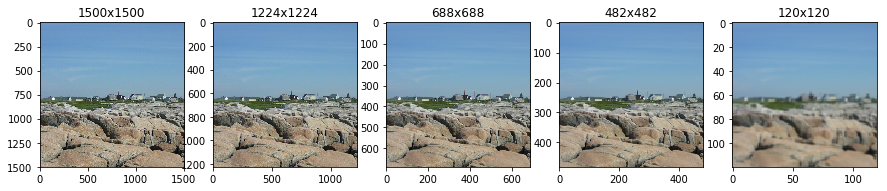

In [579]:
plt.figure(figsize=[15,8])
blur_levels = len(sigmas)
for idx, f in enumerate(pyr):
    plt.subplot(1,blur_levels,idx+1)
    plt.imshow(f/255.);
    plt.title(str(np.shape(f)[0])+'x'+str(np.shape(f)[1]))